## Analysis flat plate boundary layer data

In [24]:
import yt
import numpy as np
import matplotlib.pyplot as plt

In [25]:
datasets = ["WENOZ190/plt08000", "WENOZ95/plt15000", "WENOZ48/plt21000"]#, "WENOZ24/plt15000"]
dx = 21/64 / 2**np.array([3, 4, 5, 6])
dy =  4/64 / 2**np.array([3, 4, 5, 6])
L = 20.5
Tw = 300.0
Tinf = 57.8
pinf = 1530.0
M = 6.85

gamma = 1.4
R = 2.87e6
cp = 1.005e7
Pr = 0.72
mu0 = 3.94751e-05

uinf = (M*np.sqrt(gamma*R*Tinf))
rhoinf = pinf/R/Tinf

rhoinf*uinf*dy/mu0 # Re_dy

array([190.54955728,  95.27477864,  47.63738932,  23.81869466])

In [26]:
# def LineoutBoxlib(files, var_names):
#   _x = []
#   _data = []

#   for fname in files:
#     ds = yt.load(fname)

#     xaxis = 0  # take a line cut along the x axis
#     lineout = ds.ortho_ray(xaxis, (0, 0))
#     srt = np.argsort(lineout["index", "x"])
#     x = np.array(lineout["index", "x"][srt]) - 0.5
#     _x.append(x)

#     data = np.zeros((len(var_names), x.size))
#     for i in range(len(var_names)):
#       data[i,:] = np.array(lineout["boxlib", var_names[i]][srt])  
#     _data.append(data)
  
#   return _x, _data

def Diffy2(fname, vname, dy, uw):
  """ 
  Second order differential approximation
  """
  ds = yt.load(fname)

  xaxis = 0  # take a line cut along the x axis

  y1 = dy/2
  lineout = ds.ortho_ray(xaxis, (y1, 0)) # plane coordinates: if casting along x, this is (y, z)
  srt = np.argsort(lineout["index", "x"])
  x = np.array(lineout["index", "x"][srt]) - 0.5
  u1 = np.array(lineout["boxlib", vname][srt])  
  
  y2 = dy/2 + dy
  lineout = ds.ortho_ray(xaxis, (y2, 0))
  srt = np.argsort(lineout["index", "x"])
  u2 = np.array(lineout["boxlib", vname][srt])
  
  dudy = (y2**2*u1 - y1**2*u2 + uw*(y1**2-y2**2)) / (y1*y2*(y2-y1))

  return x[x>0], dudy[x>0]

def rms(x):
  return np.sqrt(np.mean(x**2))

def Lineout(fname, vname):
  ds = yt.load(fname)

  xaxis = 0  # take a line cut along the x axis
  lineout = ds.ortho_ray(xaxis, (0, 0))
  srt = np.argsort(lineout["index", "x"])
  x = np.array(lineout["index", "x"][srt]) - 0.5
  data = np.array(lineout["boxlib", vname][srt])
  
  return x[x>0], data[x>0]

### Step 1: Find the reference temperature ($T^*$)
$$ \frac{T^*}{T_e} = 0.42 + 0.58 \frac{T_w}{T_e} + 0.032 M_e^2. $$
Subscript $e$ denotes conditions at the edge of the boundary layer, they are assumed to be the same as the freestream consitions as the oblique shock is weak.

In [27]:
def GetStarQuantities(Tw, Te, pe, Me, gamma, Pr):
  Tstar = (0.42 + 0.58*Tw/Te + 0.032*Me**2) * Te # Eckert, laminar
  # Tstar = (0.45 + 0.55*Tw/Te + 0.16*np.sqrt(Pr)*(gamma-1)/2*Me**2) * Te # Meador-Smart, laminar
  # Tstar = (0.5 + 0.5*Tw/Te + 0.16*Pr**(1/3)*(gamma-1)/2*Me**2) * Te     # Meador-Smart, turbulent
  rhostar = pe / R / Tstar
  mustar = mu0 * (Tstar / Tinf)**1.5 * (Tinf + 110.4) / (Tstar + 110.4)
  return Tstar, rhostar, mustar

### Step 2: Calculate $\rho^*$, $\mu^*$ using $T^*$ and find
$$ Re_x^* = \frac{\rho^* u_e x}{\mu^*}, \qquad C_f^* = \frac{\tau_w}{\frac{1}{2} \rho^* u_e^2} \approx \frac{0.664}{\sqrt{Re_x^*}}, \qquad St^* = \frac{q_w}{\rho^* u_e c_p (T_{aw} - T_w)} \approx \frac{C_f^*}{2} {Pr^*}^{-2/3}, $$
where $\tau_w = \mu \frac{\partial u}{\partial y}|_w$ is the wall shear stress and $q_w = \mu c_p / Pr \frac{\partial T}{\partial y}|_w$ is the wall heat flux. $Pr^* \approx Pr$ and $T_{aw}$ is the adiabatic wall temperature, given as
$$ \frac{T_{aw}}{T_e} = 1 + \sqrt{Pr} \frac{\gamma-1}{2}M_e^2. $$

In [28]:
Taw = Tinf + np.sqrt(Pr)*((gamma-1)/2*M**2)*Tinf
muw = mu0 * (Tw / Tinf)**1.5 * (Tinf + 110.4) / (Tw + 110.4)

x = []
Rexstar = []
Cfstar = []
Ststar = []
tauw = []
rho = []

for i in range(len(datasets)):
  _x, dudy = Diffy2(datasets[i], "x_velocity", dy[i], 0.0)
  x.append(_x)

  Tstar, rhostar, mustar = GetStarQuantities(Tw, Tinf, pinf, M, gamma, Pr)
  Rexstar.append(rhostar * uinf * _x / mustar)

  # _, Tloc = Lineout(datasets[i], "temp")
  # mu = mu0 * (Tloc / Tinf)**1.5 * (Tinf + 110.4) / (Tloc + 110.4)
  mu = muw
  tauw.append(mu*dudy)
  Cfstar.append(mu*dudy/(0.5*rhostar*uinf**2))
  
  _, dTdy = Diffy2(datasets[i], "temp", dy[i], Tw)
  # qw.append(cp*mu/Pr*dTdy) # kappa = cp*mu/Pr
  Ststar.append(cp*mu/Pr*dTdy/(rhostar*uinf*cp*(Taw-Tw)))

  _, _rho = Lineout(datasets[i], "density")
  rho.append(_rho)

yt : [INFO     ] 2023-06-08 14:26:34,669 Parameters: current_time              = 0.00087820835572706
yt : [INFO     ] 2023-06-08 14:26:34,670 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2023-06-08 14:26:34,671 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-06-08 14:26:34,672 Parameters: domain_right_edge         = [21.  4.  1.]
yt : [INFO     ] 2023-06-08 14:26:35,005 Parameters: current_time              = 0.00087820835572706
yt : [INFO     ] 2023-06-08 14:26:35,006 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2023-06-08 14:26:35,007 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-06-08 14:26:35,008 Parameters: domain_right_edge         = [21.  4.  1.]
yt : [INFO     ] 2023-06-08 14:26:35,399 Parameters: current_time              = 0.00087820835572706
yt : [INFO     ] 2023-06-08 14:26:35,400 Parameters: domain_dimensions         = [64 64  1]
yt : [INFO     ] 2023-06-08 14:26:35,401 Parame

### Experimental data
Figure 32 in Smith, A. J. D. (1993). *The dynamic response of a wedge separated hypersonic flow and its effects on heat transfer*. PhD thesis, University of Southampton. 

In [29]:
exp_data = np.genfromtxt('ref_data.csv', delimiter=',')
exp_data[:,1] = exp_data[:,1] * M**2
exp_data[:,3] = exp_data[:,3] * M**2

### Plotting

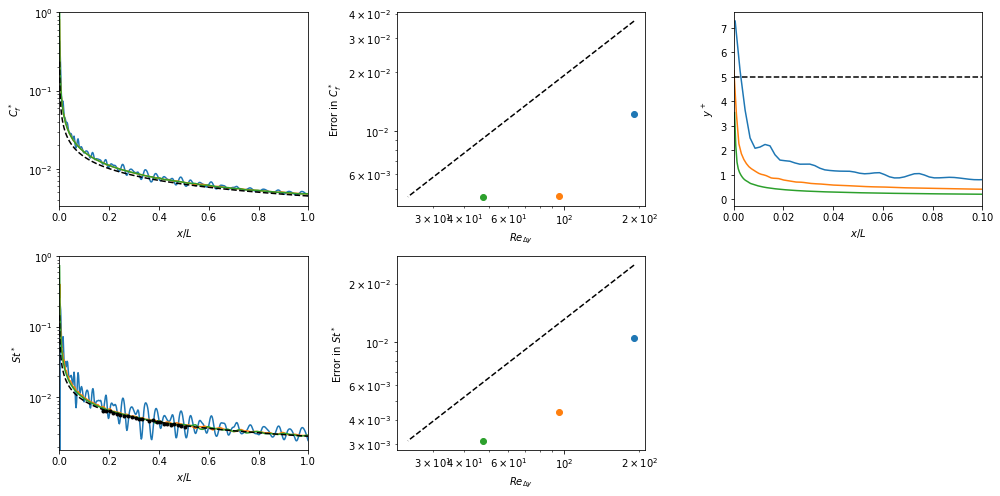

In [30]:
plt.figure(figsize=(14,7))

for i in range(len(datasets)):
  plt.subplot(2,3,1)
  plt.semilogy(x[i]/L, Cfstar[i])

  plt.subplot(2,3,2)
  err_Cfstar = rms(Cfstar[i][x[i]>0.05]-0.664/np.sqrt(Rexstar[i][x[i]>0.05]))
  plt.loglog(rhoinf*uinf*dy[i]/mu0, err_Cfstar, 'o')
  
  plt.subplot(2,3,3)
  plt.plot(x[i]/L, dy[i]*np.sqrt(rho[i]*tauw[i])/muw)

  plt.subplot(2,3,4)
  plt.semilogy(x[i]/L, Ststar[i])

  plt.subplot(2,3,5)
  err_Ststar = rms(Ststar[i][x[i]>0.05]-0.5*0.664/np.sqrt(Rexstar[i][x[i]>0.05])*Pr**(-2/3))
  plt.loglog(rhoinf*uinf*dy[i]/mu0, err_Ststar, 'o')

plt.subplot(2,3,1)
plt.semilogy(x[-1]/L, 0.664/np.sqrt(Rexstar[-1]), 'k--')
plt.ylabel(r"$C_f^*$")
plt.xlabel(r"$x/L$")
plt.xlim([0.0, 1.0])
plt.ylim([None, 1.0])

plt.subplot(2,3,2)
plt.loglog(rhoinf*uinf*dy/mu0, err_Cfstar*dy/dy[-1], 'k--') # use the last point
plt.ylabel(r"Error in $C_f^*$")
plt.xlabel(r"$Re_{\Delta y}$")

plt.subplot(2,3,3)
plt.plot([0.0, 1.0], [5.0, 5.0], 'k--')
plt.ylabel(r"$y^+$")
plt.xlabel(r"$x/L$")
plt.xlim([0.0, 0.1])

plt.subplot(2,3,4)
plt.semilogy(x[-1]/L, 0.5*0.664/np.sqrt(Rexstar[-1])*Pr**(-2/3), 'k--') # Pr* = Pr because cp is const with T
plt.semilogy(exp_data[:,2]/L, exp_data[:,3], 'k.') 
plt.ylabel(r"$St^*$")
plt.xlabel(r"$x/L$")
plt.xlim([0.0, 1.0])
plt.ylim([None, 1.0])

plt.subplot(2,3,5)
plt.loglog(rhoinf*uinf*dy/mu0, err_Ststar*dy/dy[-1], 'k--') # use the last point
plt.ylabel(r"Error in $St^*$")
plt.xlabel(r"$Re_{\Delta y}$")

plt.tight_layout()